## Testing functions for get_data(). Download + extract and local stored data. 

In [1]:
# libraries 

import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np 
import random 
import os
import requests
import zipfile 

from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 

from dataclasses import dataclass

bold = '\033[1m'
end = '\033[0m'


In [2]:
# dataclass 

@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE: int= 42
    ROOT_DIR: str = r"C:\Users\Khemra\Desktop\OpenCV\Functions\Get Data\dataset_balls"
    IMG_HEIGHT: int = 224
    IMG_WIDTH: int = 224
    CHANNELS: int = 3
    BATCH_SIZE: int = 32 


In [3]:
# set seeds()

def set_seeds():

    random.seed(DatasetConfig.SEED_VALUE)
    np.random.seed(DatasetConfig.SEED_VALUE)
    tf.random.set_seed(DatasetConfig.SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"]="1"

    physical_devices = tf.config.list_physical_devices("GPU")

    try: 
        tf.config.experimental.set_memory_growth(physical_devices[0], training=True)
    except:
        pass # for incompatible devices or not able to modify after initalizing 

    return

set_seeds()

In [4]:
# get_data

def get_data_download(save_name, url):

    url=url
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)


# extract downloaded zip file 

def extract_file(zip_file=None):

    try: 
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
        print("File Extracted")
    except:
        print("File incompatible")

# Call function 

# get_data_download('dataset_balls.zip', 'https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1')
# extract_file(zip_file='dataset_balls.zip')



# Display directory structure ()

In [5]:
train_dir = os.path.join(DatasetConfig.ROOT_DIR, "train")
valid_dir = os.path.join(DatasetConfig.ROOT_DIR, "valid")


def directory_structure(root_dir):

    for root, _, file in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')

    # number of files from train and valid folders 

    num_train_files = 0 
    num_valid_files = 0 

    for path in os.listdir(train_dir):
        num_train_files += len(os.listdir(os.path.join(train_dir, path)))

    for path in os.listdir(valid_dir):
        num_valid_files += len(os.listdir(os.path.join(valid_dir, path)))

    print(f'{bold}Number of train files: {end}{num_train_files}')
    print(f'{bold}Number of valid files: {end}{num_valid_files}')

In [6]:
directory_structure(DatasetConfig.ROOT_DIR)


dataset_balls
    train   
        baseball
        basketball
        beachballs
        billiard ball
        bowling ball
        brass   
        buckeyballs
        cannon ball
        cricket ball
        eyeballs
    valid   
        baseball
        basketball
        beachballs
        billiard ball
        bowling ball
        brass   
        buckeyballs
        cannon ball
        cricket ball
        eyeballs
Number of train files: 1125
Number of valid files: 200


### Display sample images with shape and class names. 

Original data: shape and color mode.
- if the plt.title(label=f'{}') is not fitting/overlapping text, change the plt.subplot() for cols and rows. Lower values has larger tile images.

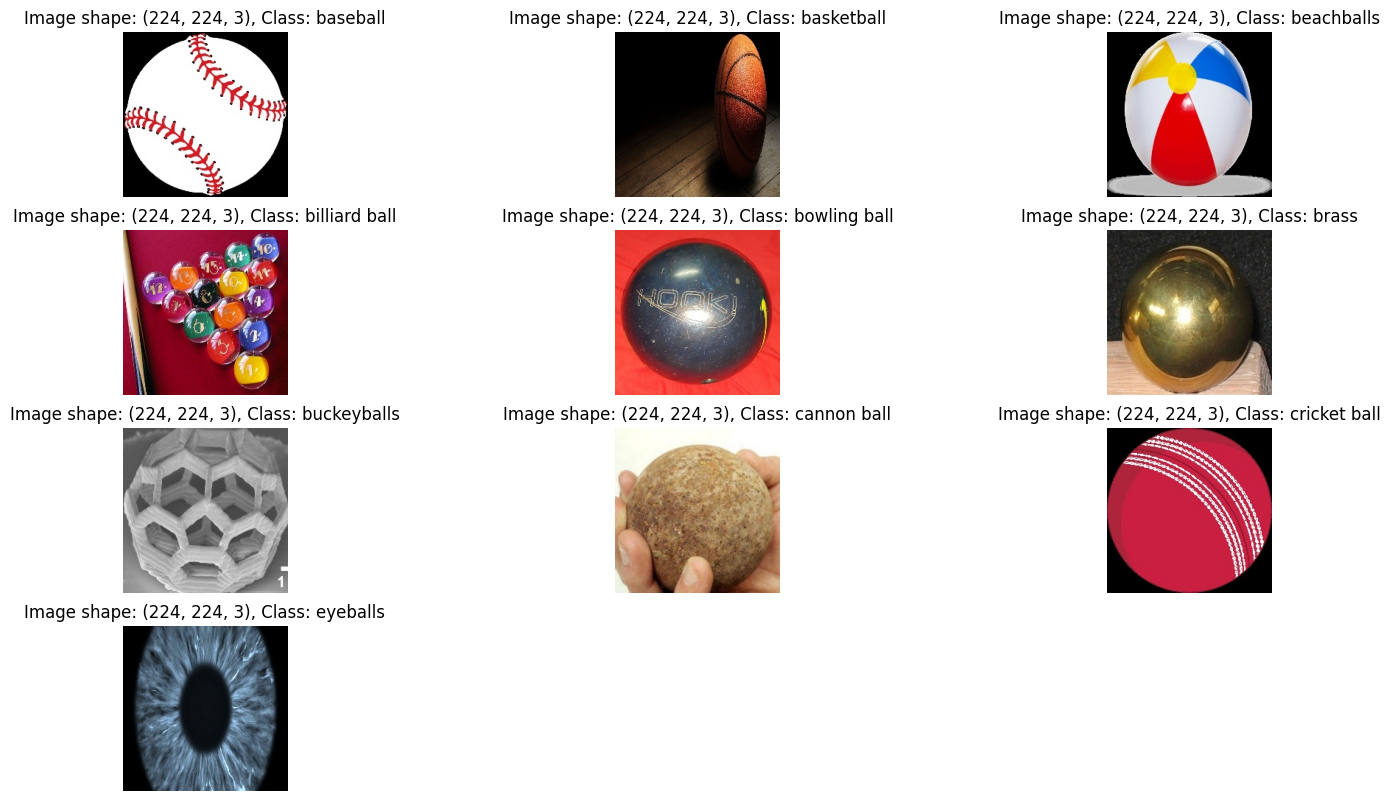

In [7]:
def display_sample_images(train_dir):

    class_names = os.listdir(train_dir)
    plt.figure(figsize=(18, 15))

    for idx, class_names in enumerate(class_names):
        ax = plt.subplot(6, 3, idx + 1)
        img_tensor = tf.keras.utils.img_to_array(Image.open(os.path.join(train_dir, class_names, os.listdir(os.path.join(train_dir, class_names))[0])))
        img_shape = img_tensor.shape 
        # truth_idx = np.nonzero(class_names[idx].numpy())
        plt.imshow(Image.open(os.path.join(train_dir, class_names, os.listdir(os.path.join(train_dir, class_names))[0])))
        plt.title(label="Image shape: {}".format(img_shape)+ ", Class: {}".format(class_names)) 
        plt.axis("off")

display_sample_images(train_dir=train_dir)

### get_data using image_dataset_from_directory() 
To preprocess 

In [8]:
# get get_preprocess_data()

def get_preprocess_data():

    train_dataset = image_dataset_from_directory(
        train_dir,
        label_mode='categorical',
        color_mode='rgb',
        image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
        batch_size=DatasetConfig.BATCH_SIZE,
        shuffle=True
    )

    valid_dataset = image_dataset_from_directory(
        valid_dir,
        label_mode='categorical',
        color_mode='rgb',
        image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
        batch_size=DatasetConfig.BATCH_SIZE,
        shuffle=False,
    )

    return train_dataset, valid_dataset

In [9]:
train_dataset, valid_dataset = get_preprocess_data()

Found 1125 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


### Display the preprocessed data ()

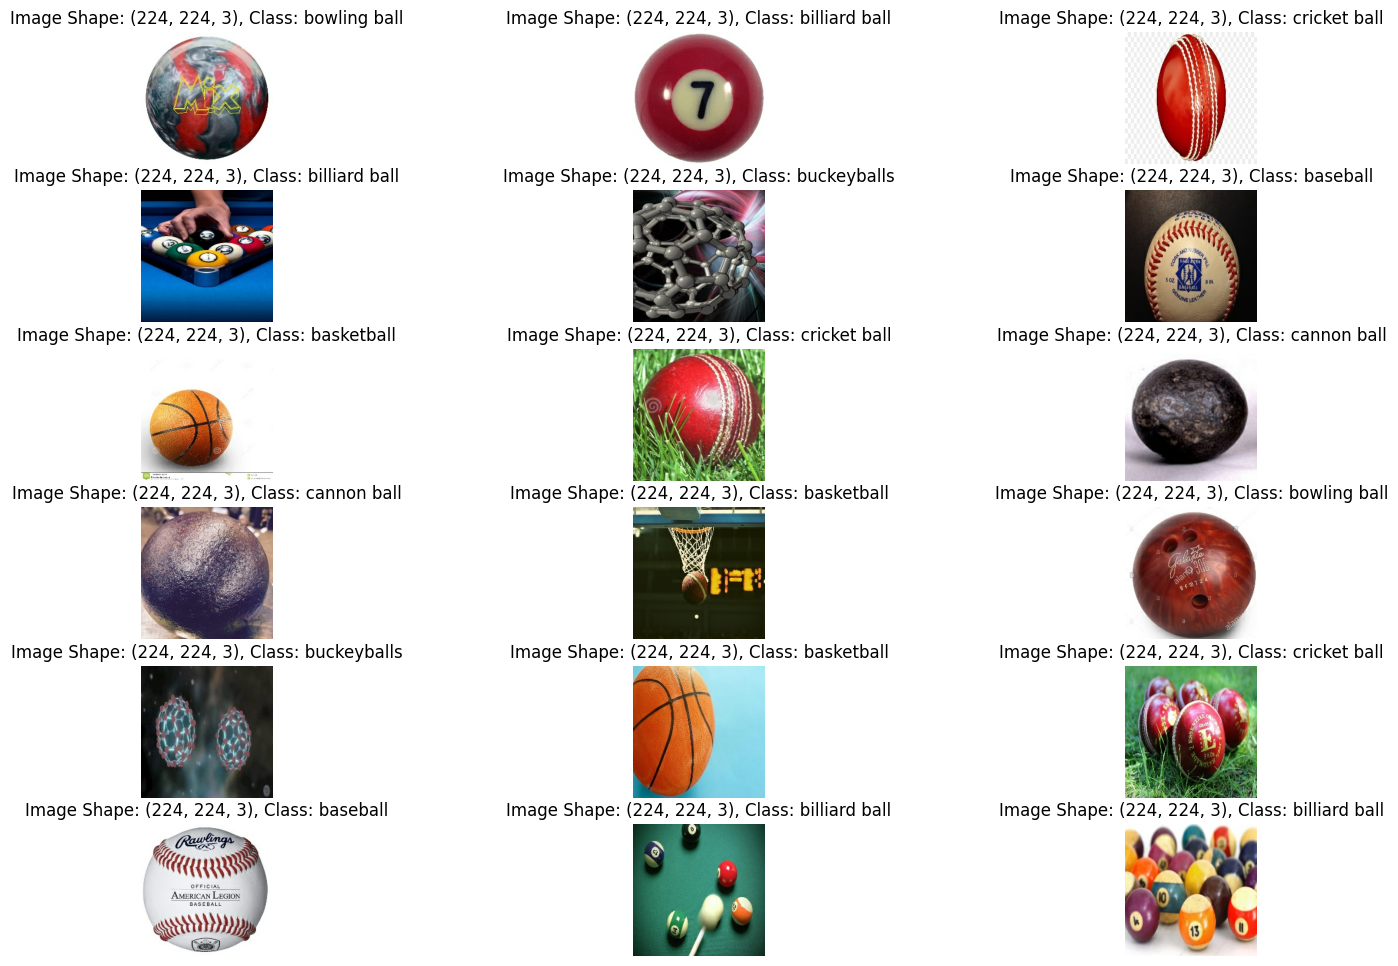

In [10]:
def display_preprocessed_datasets():

    class_names = train_dataset.class_names 
    plt.figure(figsize=(18, 12))

    for image_batch, label_batch in train_dataset.take(1):

        for idx in range(18): # num of imgs to display 
            img_tensor = tf.keras.utils.img_to_array(image_batch[idx])
            img_tensor = tf.cast(img_tensor, tf.float32)
            img_shape = img_tensor.shape
            ax = plt.subplot(6, 3, idx + 1) # rows, cols 
            plt.imshow(image_batch[idx].numpy().astype("uint8"))
            truth_idx = np.nonzero(label_batch[idx].numpy())
            plt.title(label='Image Shape: {}'.format(img_shape) + ', Class: {}'.format(class_names[truth_idx[0][0]]))
            plt.axis('off')


display_preprocessed_datasets()


### Augmentation Layer 
* Pipeline/layer/block()
* Individual layers to show augmentation 

In [11]:
def augmenation_pipeline():
    augmentation_layer = tf.keras.Sequential([

    tf.keras.layers.RandomRotation(0.15, fill_mode='nearest', seed=2000),
    tf.keras.layers.RandomFlip(mode='horizontal', seed=2000),
    tf.keras.layers.RandomZoom(height_factor=(0.5),  width_factor=(0.5), fill_mode='nearest') # factors: positve values=zoom out; negative_values=zoom_in 
])
    
    return augmentation_layer



In [12]:
# individual augmentation to show output 

rand_rotation = tf.keras.layers.RandomRotation(0.25, fill_mode='nearest', seed=2000)
rand_flip = tf.keras.layers.RandomFlip(mode='horizontal', seed=2000)
rand_zoom = tf.keras.layers.RandomZoom(height_factor=(0.5),  width_factor=(0.5), fill_mode='nearest')

### Apply Augmentation Layer to Images

In [17]:
def display_augmentation_rows(dataset, augmenation_layer, num_passes=7, label=None):
    """
    num_passes: int = how many times to apply the layer to the image 
    label: str = what type of augmentation being applied 
    augmentaion_layer: str = the augmentation layer to use 
    
    """

    random.seed(DatasetConfig.SEED_VALUE)
    plt.figure(figsize=(20, 5))

    # Get a single image batch 
    for image_batch, _, in dataset.take(1):

        for i in range(num_passes):
            augmented_images = augmenation_layer(image_batch)

            # display 
            ax = plt.subplot(1, num_passes, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

        break 
    print('\n')
    if label:
        print(f"{bold}", label)
    plt.show(block=False)





 Rotation:


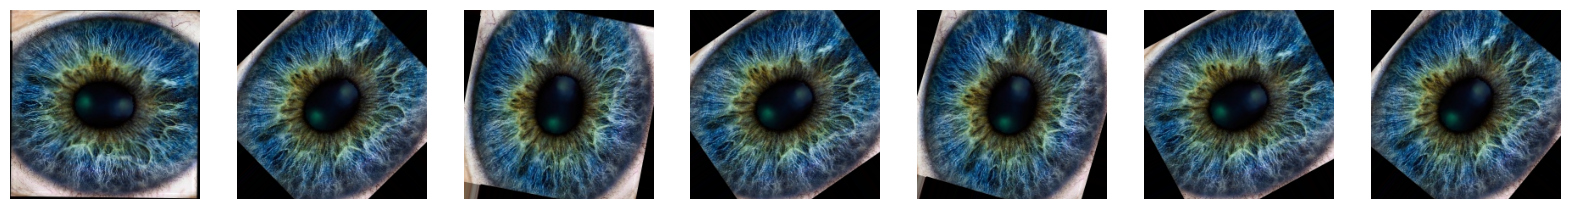

In [14]:
display_augmentation_rows(train_dataset, rand_rotation, num_passes=7, label='Rotation:')

In [20]:
def display_augmentation_grid(dataset, augmentation_layer):
    
    random.seed(DatasetConfig.SEED_VALUE)
    num_rows = 4
    num_cols = 6
    num_passes = 6*4
    plt.figure(figsize=(18, 12))
    augmentation_layer = augmenation_pipeline()

    for image_batch, _, in dataset.take(1):
        for idx in range(num_passes):
            augmented_imgs = augmentation_layer(image_batch)
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(augmented_imgs[0].numpy().astype("uint8")) # [0] for one class use [idx] to iterate through all classes
            plt.axis("off")
    plt.show(block=False)

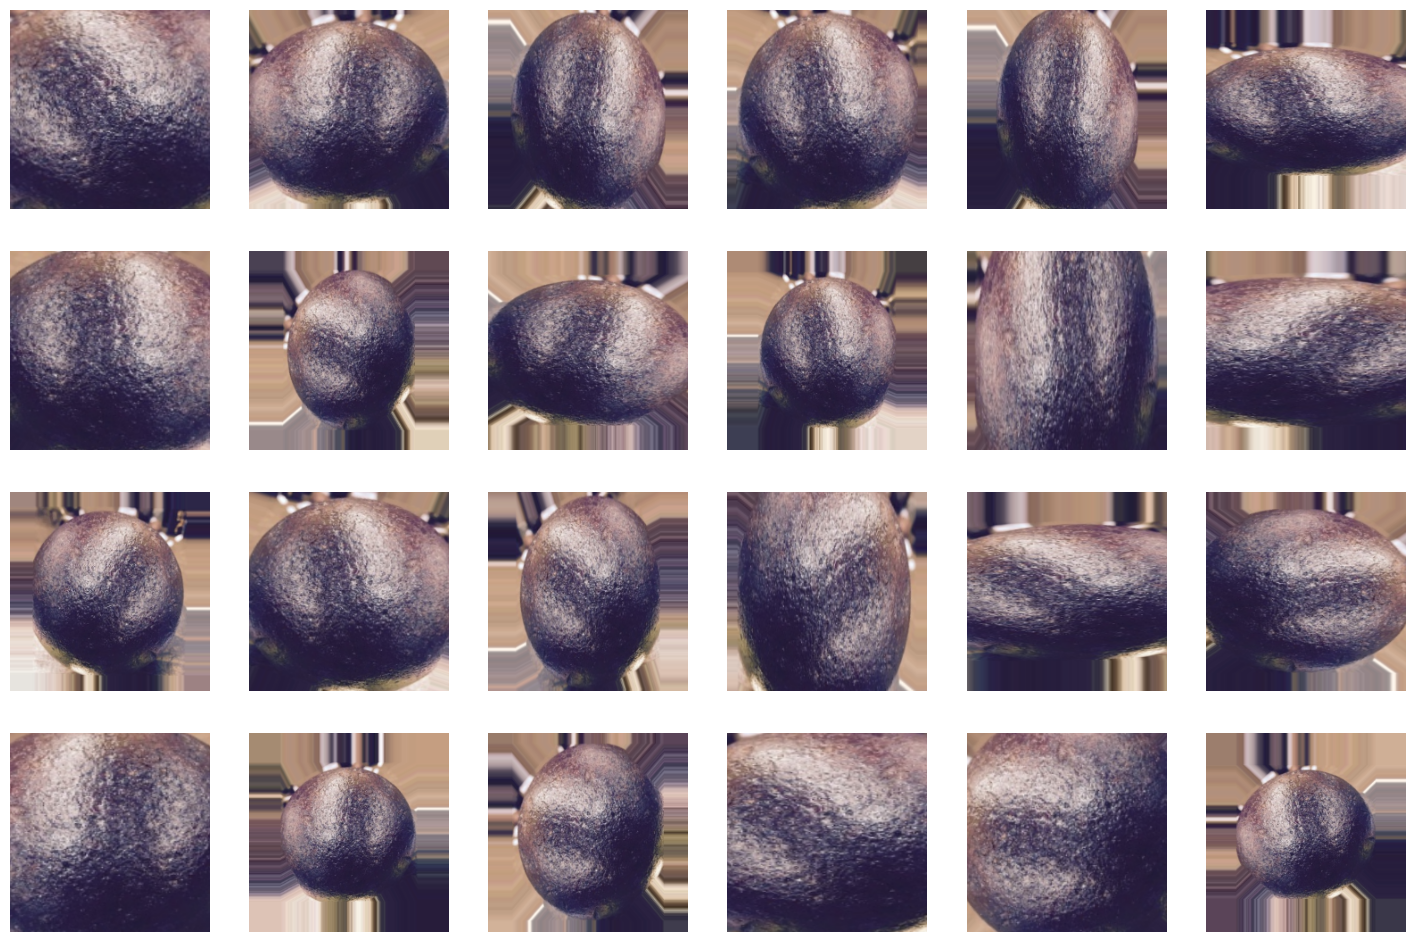

In [21]:
display_augmentation_grid(train_dataset, augmenation_pipeline)